In [13]:
import numpy as np
from scipy.linalg import expm
import matplotlib.pyplot as plt
from itertools import combinations

In [14]:
def get_coherence(h_bath, time_grid):
    """Calculates L(t) for a given cluster Hamiltonian manifold."""
    H_up, H_down = h_bath
    dim = H_up.shape[0]
    coherence = []
    for t in time_grid:
        U_up = expm(-1j * H_up * t)
        U_down = expm(-1j * H_down * t)
        L_t = np.trace(U_up @ U_down.conj().T) / dim
        coherence.append(L_t)
    return np.array(coherence)

In [15]:
# --- Configuration ---
n_bath = 5
times = np.linspace(0, 10, 200)

# Randomly generate coupling constants for 5 spins
np.random.seed(42)
A = np.random.uniform(0.5, 2.0, n_bath)  # hyperfine couplings between central spin and bath spins
B = np.random.uniform(0.1, 0.4, (n_bath, n_bath)) # dipolar coupling between bath spins (symmetric) 
B = (B + B.T) / 2

# Operators
Iz = 0.5 * np.array([[1, 0], [0, -1]])
I2 = np.eye(2)

In [16]:
# --- 1. CCE-1 Calculation ---
l_singles = {}
cce1_total = np.ones(len(times), dtype=complex)

for i in range(n_bath):
    # H_manifold = +/- 0.5 * A_i * sigma_z
    L_i = get_coherence([A[i]*Iz, -A[i]*Iz], times)
    l_singles[i] = L_i
    cce1_total *= L_i

In [19]:
# --- 2. CCE2 Calculation (Pairs) ---
cce2_total = np.copy(cce1_total)

# Find all unique pairs: (0,1), (0,2)... (3,4)
for i, j in combinations(range(n_bath), 2):
    # Build 2-spin Hilbert space
    Iz_i = np.kron(Iz, I2)
    Iz_j = np.kron(I2, Iz)
    
    #With no flip-flopping
    H_interaction = B[i, j] * (Iz_i @ Iz_j)

    #With a "Flip-Flop" or Dipolar-like interaction:
    #Ix = 0.5 * np.array([[0, 1], [1, 0]])
    #Iy = 0.5 * np.array([[0, -1j], [1j, 0]])

    #Ip_i = np.kron(Ix+1j*Iy, I2)
    #Ip_j = np.kron(I2, Ix+1j*Iy)
    #Im_i = np.kron(Ix-1j*Iy, I2)
    #Im_j = np.kron(I2, Ix-1j*Iy)

    # This interaction allows spins to swap states
    #H_interaction = B[i, j] * (Ip_i @ Im_j + Im_i @ Im_j + Iz_i @ Iz_j)
    
    H_pair_up = A[i]*Iz_i + A[j]*Iz_j + H_interaction
    H_pair_down = -A[i]*Iz_i - A[j]*Iz_j + H_interaction
    
    L_ij = get_coherence([H_pair_up, H_pair_down], times)
    
    # Extract the irreducible correlation: L_ij / (L_i * L_j)
    tilde_L_ij = L_ij / (l_singles[i] * l_singles[j])
    cce2_total *= tilde_L_ij

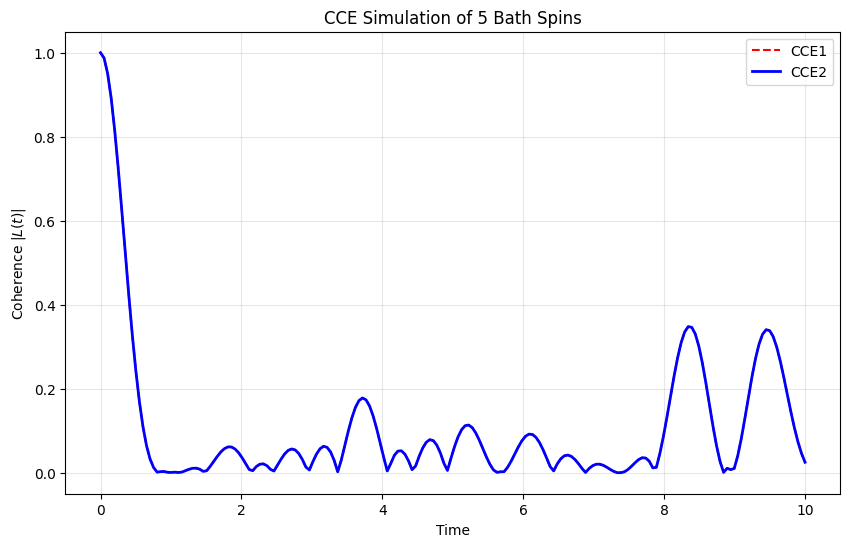

In [20]:
# --- Plotting ---
plt.figure(figsize=(10, 6))
plt.plot(times, np.abs(cce1_total), 'r--', label='CCE1')
plt.plot(times, np.abs(cce2_total), 'b-', linewidth=2, label='CCE2')
plt.title(f'CCE Simulation of {n_bath} Bath Spins')
plt.xlabel('Time')
plt.ylabel('Coherence $|L(t)|$')
plt.legend()
plt.grid(alpha=0.3)
plt.show()